In [1]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ViT_myWorks/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
!pip install -q torchmetrics
!pip install --upgrade pytorch-pretrained-vit
!pip install efficientnet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=fa75f0011f9b8d01b98297d652848382415303385f61543da82e4a0fcf4d4d79
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=dab8c5f8e6a5ba5d4c7f7f5bd2e2132a8bb8762829255726c35b140572a7d8ea
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
import math
import scipy.io as sio
from efficientnet_pytorch import EfficientNet

In [4]:
from resViT.model import *
from resViT.train import *
from resViT.loaddata import *

In [5]:
tarData = ['FE_tar_7_1', 'FE_tar_7_2', 'FE_tar_7_3', 'FE_tar_14_1', 'FE_tar_14_2',
           'FE_tar_14_3', 'FE_tar_21_1', 'FE_tar_21_2', 'FE_tar_21_3', 'ims_tar'];

root_path = './cwruData/' #running from local
img_size=128

# EDA

In [ ]:
tar = 0
# root = '/content/cwruData/' + tarData[tar] + '/' #Running from colab
root = './cwruData/' + tarData[tar] + '/' #Running from local
classNames = ['n', 'ir', 'b', 'or']
numClass = len(classNames)
label_map = {i : className for i, className in enumerate(classNames)}
print(f'\nLabels are mapped as\n {label_map}')


Labels are mapped as
 {0: 'n', 1: 'ir', 2: 'b', 3: 'or'}


In [ ]:
Train = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'train', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Train  = pd.concat((Train, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Train.head()

,img,label
0,./cwruData/FE_tar_7_1/train\n\n184.png,0
1,./cwruData/FE_tar_7_1/train\n\n217.png,0
2,./cwruData/FE_tar_7_1/train\n\n219.png,0
3,./cwruData/FE_tar_7_1/train\n\n216.png,0
4,./cwruData/FE_tar_7_1/train\n\n218.png,0


In [ ]:
len(Train)

1024

In [ ]:
Test = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'test', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Test  = pd.concat((Test, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Test.head()

,img,label
0,./cwruData/FE_tar_7_1/test\n\n51.png,0
1,./cwruData/FE_tar_7_1/test\n\n76.png,0
2,./cwruData/FE_tar_7_1/test\n\n75.png,0
3,./cwruData/FE_tar_7_1/test\n\n35.png,0
4,./cwruData/FE_tar_7_1/test\n\n62.png,0


In [ ]:
len(Test)

320

In [ ]:
Val = pd.DataFrame(columns = ['img', 'label'])
j=0
for i in label_map:
  img_path = os.path.join(root, 'val', label_map[i])
  for img in os.listdir(img_path):
    image = os.path.join(img_path, img)
    Val  = pd.concat((Val, pd.DataFrame({'img':[image], 'label': i})), ignore_index = True)
    j+=1
Val.head()

,img,label
0,./cwruData/FE_tar_7_1/val\n\n26.png,0
1,./cwruData/FE_tar_7_1/val\n\n29.png,0
2,./cwruData/FE_tar_7_1/val\n\n28.png,0
3,./cwruData/FE_tar_7_1/val\n\n30.png,0
4,./cwruData/FE_tar_7_1/val\n\n27.png,0


In [ ]:
len(Val)

256

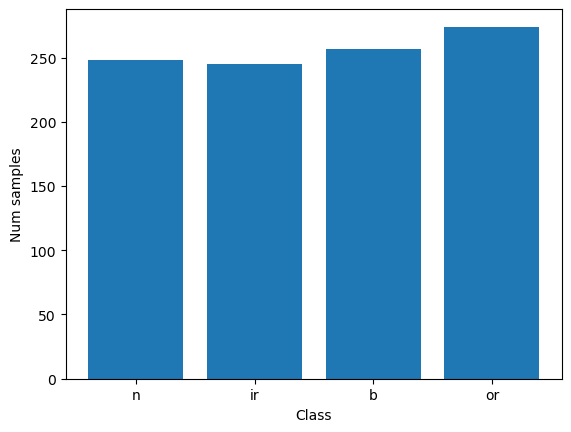

In [ ]:
def vis_data_class_distribution(labels, class_names):
    #   labels: list of integers representing the class of each samples
    #   class_names: a list of class names corresponding to each class
    counts = [sum(labels == c) for c in range(len(class_names))]
    # plt.title(f'Data class distribution')
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Num samples')
    plt.show()

vis_data_class_distribution(Train['label'],  classNames)

# Proposed ViT training with Knowledge transfer method

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = torch.load('./saved_models/ViT_src_7_0.pth', map_location=device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.00001)
    criterion = nn.CrossEntropyLoss() #Define classification loss
    print(f'Fine tuning model for traget data: {tarData[tar]}')
    Model = train_pr(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ViT_'+tarData[tar]+'.pth')

Fine tuning model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 73.67    Val Accuracy = 86.09
[1/20]   Train Accuracy = 89.45    Val Accuracy = 90.34
[2/20]   Train Accuracy = 94.77    Val Accuracy = 91.67
[3/20]   Train Accuracy = 95.46    Val Accuracy = 89.74
[4/20]   Train Accuracy = 97.15    Val Accuracy = 94.41
[5/20]   Train Accuracy = 97.21    Val Accuracy = 94.10
[6/20]   Train Accuracy = 97.16    Val Accuracy = 96.49
[7/20]   Train Accuracy = 97.78    Val Accuracy = 94.29
[8/20]   Train Accuracy = 97.13    Val Accuracy = 94.26
[9/20]   Train Accuracy = 98.83    Val Accuracy = 96.92
[10/20]   Train Accuracy = 98.72    Val Accuracy = 96.92
[11/20]   Train Accuracy = 98.93    Val Accuracy = 96.63
[12/20]   Train Accuracy = 99.11    Val Accuracy = 94.60
[13/20]   Train Accuracy = 98.50    Val Accuracy = 96.52
[14/20]   Train Accuracy = 99.03    Val Accuracy = 94.36
[15/20]   Train Accuracy = 99.47    Val Accuracy = 98.44
[16/20]   Train Accuracy =

Fine tuning model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 73.44    Val Accuracy = 85.94
[1/20]   Train Accuracy = 89.28    Val Accuracy = 90.69
[2/20]   Train Accuracy = 94.80    Val Accuracy = 91.49
[3/20]   Train Accuracy = 95.42    Val Accuracy = 89.69
[4/20]   Train Accuracy = 96.88    Val Accuracy = 94.37
[5/20]   Train Accuracy = 97.05    Val Accuracy = 93.78
[6/20]   Train Accuracy = 97.33    Val Accuracy = 96.12
[7/20]   Train Accuracy = 97.94    Val Accuracy = 94.50
[8/20]   Train Accuracy = 97.40    Val Accuracy = 94.43
[9/20]   Train Accuracy = 98.57    Val Accuracy = 97.08
[10/20]   Train Accuracy = 99.08    Val Accuracy = 97.15
[11/20]   Train Accuracy = 98.95    Val Accuracy = 96.79
[12/20]   Train Accuracy = 99.02    Val Accuracy = 94.88
[13/20]   Train Accuracy = 98.80    Val Accuracy = 96.87
[14/20]   Train Accuracy = 98.71    Val Accuracy = 94.70
[15/20]   Train Accuracy = 99.49    Val Accuracy = 98.47
[16/20]   Train Accuracy 

Validation Accuracy =  100.0
__________________________________________________
Pricision Score = 1.0
__________________________________________________
F_1 Score =  1.0
__________________________________________________
Recall Score =  1.0
__________________________________________________
Response time per batch 0.9179644584655762


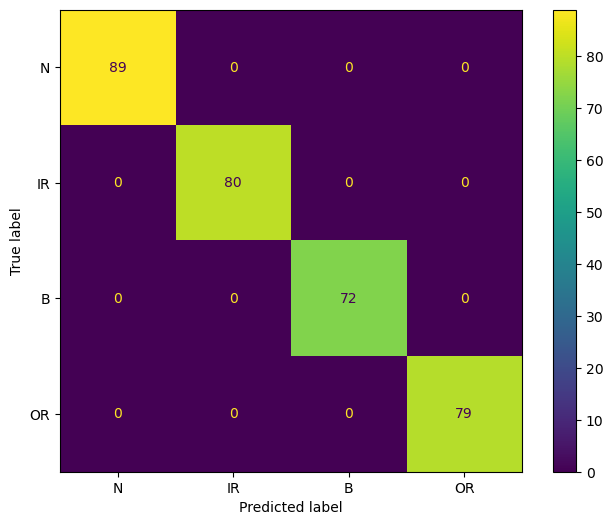

In [ ]:
# Validate and Visualize
Model = torch.load('./saved_models/ViT_'+tarData[0]+'.pth', map_location=device)
TrainLoader, TestLoader, ValLoader = loaddata(root_path, tarData[0])
val_acc, cm, prec, f1, recall, time_batch = validate_pr(Model, TestLoader, 4)
print('Validation Accuracy = ', 100*val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvit = {'Modelname':['ViT_attn'+tarData[tar]], 'Val Acc.': 100*val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [ ]:
perfvit = pd.DataFrame(perfvit)
# perfData.to_csv('results_'+ tarData[tar]+ '.csv')
perfvit

,Modelname,Val Acc.,Precision,F1_score,Recall
0,ViT_attnFE_tar_21_3,100.0,1.0,1.0,1.0


# Train benchmark models for comparisions
## Models: Standard ViT, EfficientNet, ResNeXt, DenseNet, VGGNet, GoogleNet, SqeezeNet

### Standard ViT wth 12 encoder block pre-trained in ImageNet1k

In [6]:
for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = ViTpretrain(img_size, numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning pre-trained ViT model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ViT_pre_'+tarData[tar]+'.pth')

Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16_imagenet1k.pth" to /root/.cache/torch/hub/checkpoints/B_16_imagenet1k.pth
100%|██████████| 331M/331M [00:02<00:00, 166MB/s]


Resized positional embeddings from torch.Size([1, 577, 768]) to torch.Size([1, 65, 768])
Loaded pretrained weights.
Fine tuning pre-trained ViT model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 65.62    Val Accuracy = 86.72
[1/20]   Train Accuracy = 98.24    Val Accuracy = 90.62
[2/20]   Train Accuracy = 98.44    Val Accuracy = 98.83
[3/20]   Train Accuracy = 98.63    Val Accuracy = 96.88
[4/20]   Train Accuracy = 99.61    Val Accuracy = 96.09
[5/20]   Train Accuracy = 99.80    Val Accuracy = 96.09
[6/20]   Train Accuracy = 99.02    Val Accuracy = 98.44
[7/20]   Train Accuracy = 99.71    Val Accuracy = 98.83
[8/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[9/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[11/20]   Train Accuracy = 99.02    Val Accuracy = 96.09
[12/20]   Train Accuracy = 99.80    Val Accuracy = 97.27
[13/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[14/

Validation Accuracy =  98.75
__________________________________________________
Pricision Score = 0.9878783426388481
__________________________________________________
F_1 Score =  0.9868225462379819
__________________________________________________
Recall Score =  0.9863013698630136
__________________________________________________
Response time per batch
 0.01596689224243164
Validation Accuracy =  98.75
__________________________________________________
Pricision Score = 0.987386689118186
__________________________________________________
F_1 Score =  0.9876588738172997
__________________________________________________
Recall Score =  0.9880395361133881
__________________________________________________
Response time per batch
 0.012338638305664062
Validation Accuracy =  99.6875
__________________________________________________
Pricision Score = 0.9965753424657534
__________________________________________________
F_1 Score =  0.9966202329298928
__________________________________

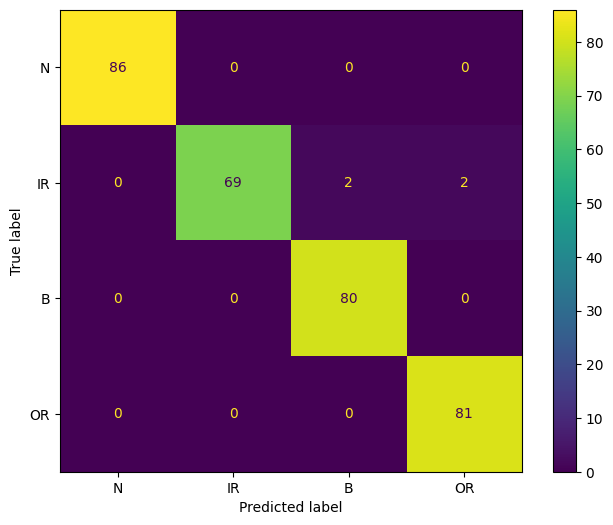

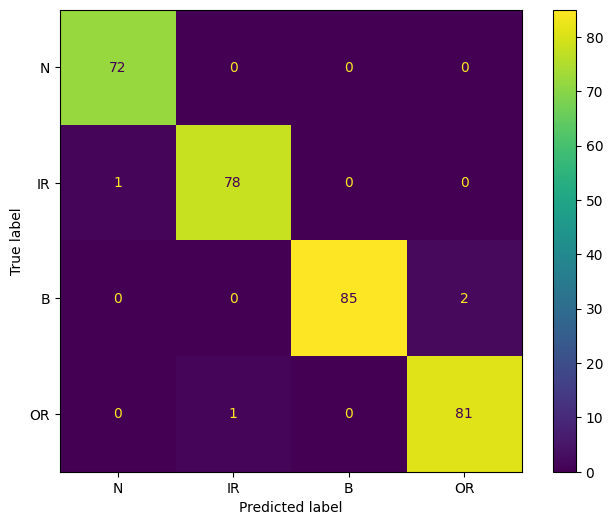

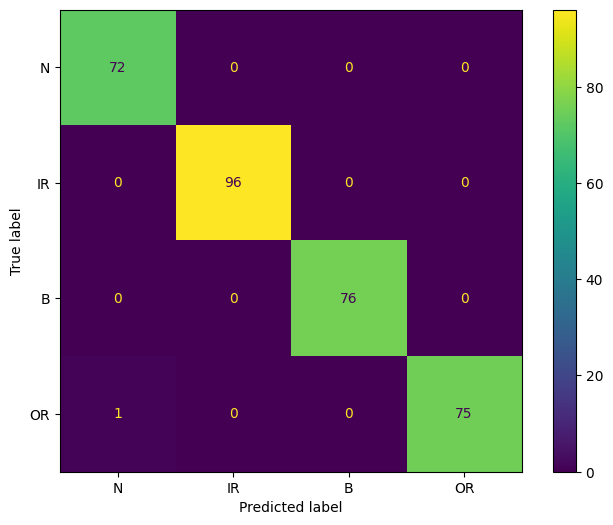

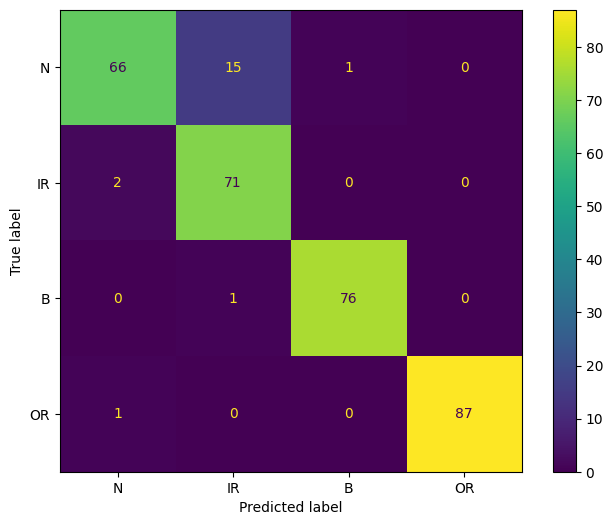

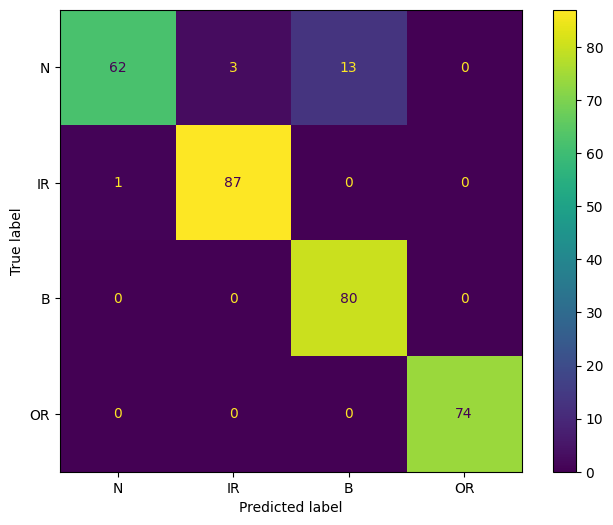

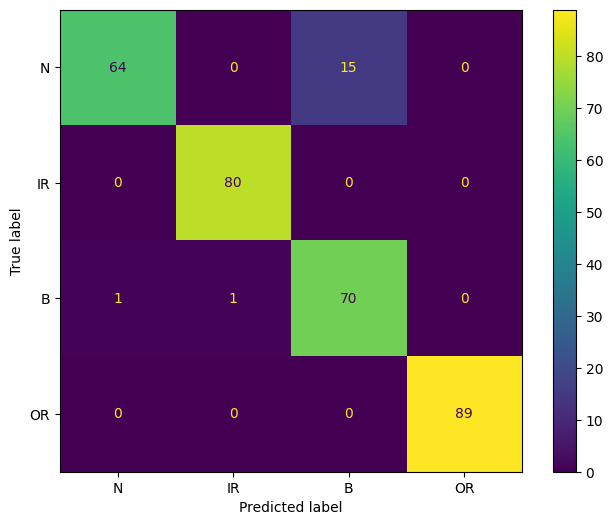

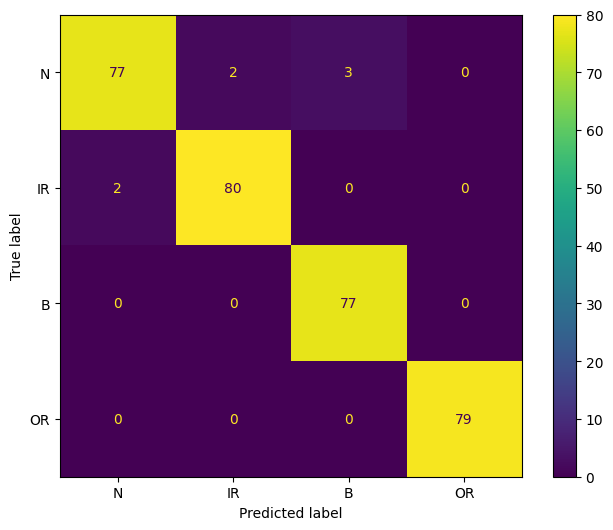

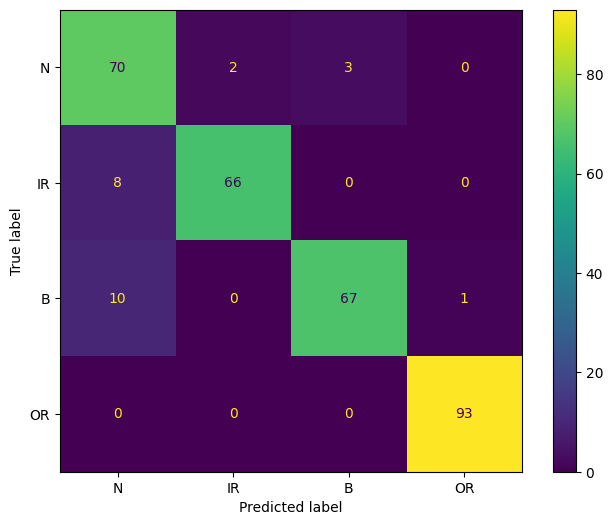

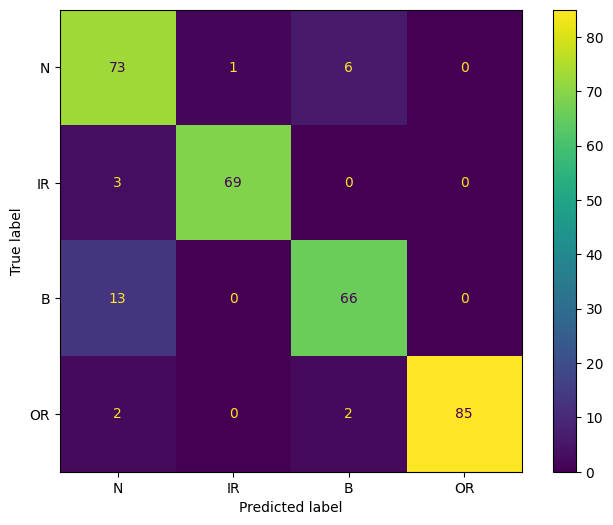

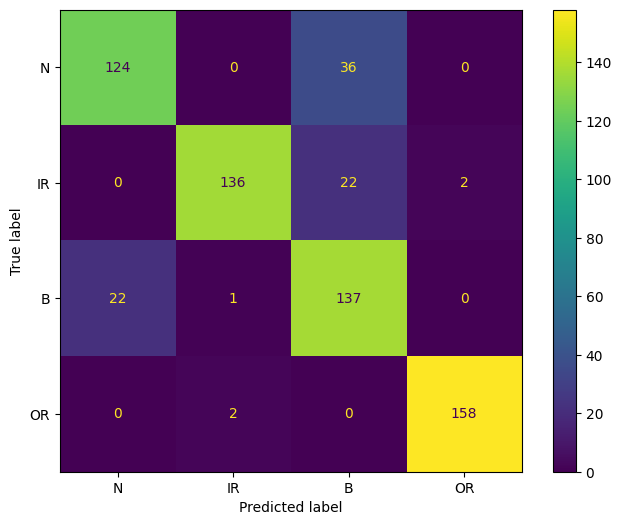

In [7]:
# Validate and Visualize
perfvit_pre = pd.DataFrame({'Metrics':['Val Acc.', 'Precision', 'F1_score', 'Recall']})
for name in tarData:
    Model = torch.load('./saved_models/ViT_pre_'+ name +'.pth', map_location=device)
    _, TestLoader, _, numClass = loaddata(root_path, name)
    val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
    print('Validation Accuracy = ', val_acc)
    print("__________________________________________________")
    print(f'Pricision Score = {prec}')
    print('__________________________________________________')
    print(f'F_1 Score =  {f1}')
    print('__________________________________________________')
    print(f"Recall Score =  {recall}")
    print('__________________________________________________')
    print('Response time per batch\n', time_batch)
    disp_conf_matrix(cm)

    perfvit_pre = pd.concat((perfvit_pre, pd.DataFrame({name : [val_acc, prec, f1, recall]})), ignore_index = True, axis=1)

### EfficientNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = EfficientNet.from_pretrained('efficientnet-b1')
    Model._fc = EffNetFC(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning EfficentNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/efficient_'+tarData[tar]+'.pth')

Validation Accuracy =  99.0625
__________________________________________________
Pricision Score = 0.9908894838613714
__________________________________________________
F_1 Score =  0.990153669236384
__________________________________________________
Recall Score =  0.9897260273972602
__________________________________________________
Response time per batch 0.0849003791809082


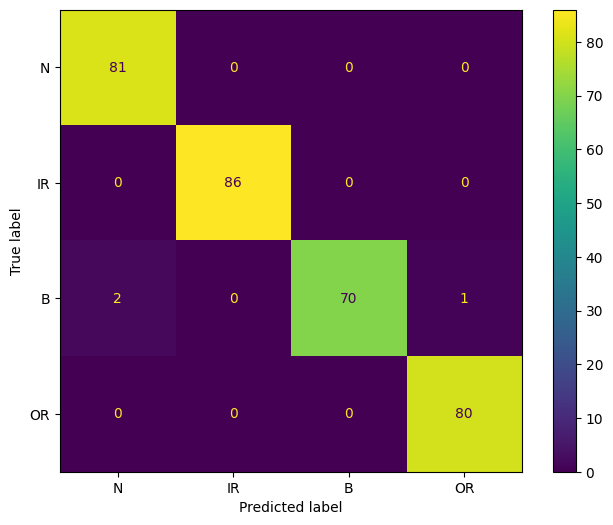

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/efficient_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, 4)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfEffNet = {'Modelname':['EfficientNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

**For IMS data**

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

tar = -1
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
Model = EfficientNet.from_pretrained('efficientnet-b1')
Model._fc = EffNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning EfficentNet model for traget data: {tarData[tar]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/efficient_'+tarData[tar]+'.pth')

Loaded pretrained weights for efficientnet-b1
Fine tuning EfficentNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 28.47    Val Accuracy = 42.77
[1/20]   Train Accuracy = 57.13    Val Accuracy = 68.55
[2/20]   Train Accuracy = 83.45    Val Accuracy = 83.79
[3/20]   Train Accuracy = 93.02    Val Accuracy = 84.57
[4/20]   Train Accuracy = 98.14    Val Accuracy = 85.16
[5/20]   Train Accuracy = 99.32    Val Accuracy = 84.38
[6/20]   Train Accuracy = 99.32    Val Accuracy = 83.79
[7/20]   Train Accuracy = 100.00    Val Accuracy = 83.98
[8/20]   Train Accuracy = 99.95    Val Accuracy = 84.38
[9/20]   Train Accuracy = 99.90    Val Accuracy = 82.81
[10/20]   Train Accuracy = 99.56    Val Accuracy = 85.55
[11/20]   Train Accuracy = 99.90    Val Accuracy = 82.62
[12/20]   Train Accuracy = 99.90    Val Accuracy = 82.42
[13/20]   Train Accuracy = 99.66    Val Accuracy = 84.18
[14/20]   Train Accuracy = 100.00    Val Accuracy = 83.79
[15/20]   Train Accuracy =

Validation Accuracy =  84.21875
__________________________________________________
Pricision Score = 0.8416983763758109
__________________________________________________
F_1 Score =  0.8406997045773441
__________________________________________________
Recall Score =  0.8421875000000001
__________________________________________________
Response time per batch 0.07323884963989258


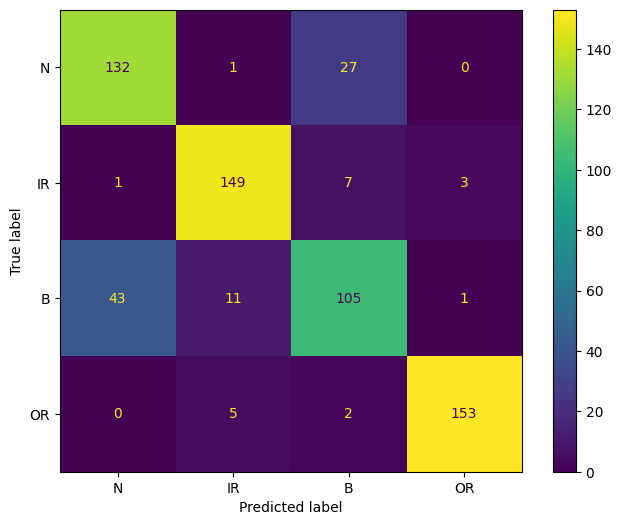

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[-1])
Model = torch.load('./saved_models/efficient_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfEffNet = {'Modelname':['EfficientNet_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### ResNeXt

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader,numClass = loaddata(root_path, tarData[tar])
    Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
    Model.fc = ResNetFC(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning ResNeXt model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/ResNeXt_'+tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 74.51    Val Accuracy = 97.66
[1/20]   Train Accuracy = 99.22    Val Accuracy = 95.31
[2/20]   Train Accuracy = 99.71    Val Accuracy = 98.44
[3/20]   Train Accuracy = 99.71    Val Accuracy = 98.44
[4/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[5/20]   Train Accuracy = 99.71    Val Accuracy = 99.22
[6/20]   Train Accuracy = 99.51    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[9/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[10/20]   Train Accuracy = 99.90    Val Accuracy = 98.44
[11/20]   Train Accuracy = 99.90    Val Accuracy = 98.83
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[14/20]   Train Accuracy = 99.51    Val Accuracy = 98.44
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 76.66    Val Accuracy = 98.44
[1/20]   Train Accuracy = 99.90    Val Accuracy = 98.44
[2/20]   Train Accuracy = 99.71    Val Accuracy = 97.66
[3/20]   Train Accuracy = 99.61    Val Accuracy = 99.61
[4/20]   Train Accuracy = 99.90    Val Accuracy = 99.61
[5/20]   Train Accuracy = 99.90    Val Accuracy = 100.00
[6/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[7/20]   Train Accuracy = 99.90    Val Accuracy = 99.22
[8/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[9/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[10/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[11/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[12/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[14/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[15/20]   Train Accuracy = 99.90    Val Accuracy = 99.61
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 71.78    Val Accuracy = 96.48
[1/20]   Train Accuracy = 99.51    Val Accuracy = 98.05
[2/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[3/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[4/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[5/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[6/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[9/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[12/20]   Train Accuracy = 99.71    Val Accuracy = 96.09
[13/20]   Train Accuracy = 99.90    Val Accuracy = 98.05
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[15/20]   Train Accuracy = 99.90    Val Accuracy = 97.27
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 68.85    Val Accuracy = 91.41
[1/20]   Train Accuracy = 98.24    Val Accuracy = 93.75
[2/20]   Train Accuracy = 99.61    Val Accuracy = 95.31
[3/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[4/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[5/20]   Train Accuracy = 99.12    Val Accuracy = 95.31
[6/20]   Train Accuracy = 99.71    Val Accuracy = 94.53
[7/20]   Train Accuracy = 99.80    Val Accuracy = 92.19
[8/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[9/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[11/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 70.80    Val Accuracy = 92.19
[1/20]   Train Accuracy = 99.32    Val Accuracy = 94.53
[2/20]   Train Accuracy = 99.71    Val Accuracy = 96.09
[3/20]   Train Accuracy = 99.41    Val Accuracy = 94.53
[4/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[5/20]   Train Accuracy = 99.51    Val Accuracy = 96.09
[6/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[8/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[9/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[13/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 74.41    Val Accuracy = 93.36
[1/20]   Train Accuracy = 98.83    Val Accuracy = 96.09
[2/20]   Train Accuracy = 99.61    Val Accuracy = 94.92
[3/20]   Train Accuracy = 99.22    Val Accuracy = 94.53
[4/20]   Train Accuracy = 99.71    Val Accuracy = 95.31
[5/20]   Train Accuracy = 99.61    Val Accuracy = 94.14
[6/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[7/20]   Train Accuracy = 99.90    Val Accuracy = 98.83
[8/20]   Train Accuracy = 98.54    Val Accuracy = 97.66
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[13/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[15/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 72.46    Val Accuracy = 91.80
[1/20]   Train Accuracy = 98.44    Val Accuracy = 94.53
[2/20]   Train Accuracy = 99.71    Val Accuracy = 97.66
[3/20]   Train Accuracy = 99.90    Val Accuracy = 98.83
[4/20]   Train Accuracy = 99.61    Val Accuracy = 94.14
[5/20]   Train Accuracy = 99.80    Val Accuracy = 96.88
[6/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[8/20]   Train Accuracy = 99.61    Val Accuracy = 98.44
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[11/20]   Train Accuracy = 99.80    Val Accuracy = 98.05
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 70.12    Val Accuracy = 86.72
[1/20]   Train Accuracy = 98.63    Val Accuracy = 88.67
[2/20]   Train Accuracy = 98.83    Val Accuracy = 88.28
[3/20]   Train Accuracy = 99.80    Val Accuracy = 89.84
[4/20]   Train Accuracy = 99.80    Val Accuracy = 89.06
[5/20]   Train Accuracy = 99.80    Val Accuracy = 91.80
[6/20]   Train Accuracy = 99.80    Val Accuracy = 92.97
[7/20]   Train Accuracy = 99.80    Val Accuracy = 91.80
[8/20]   Train Accuracy = 99.80    Val Accuracy = 92.58
[9/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[10/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[11/20]   Train Accuracy = 99.90    Val Accuracy = 92.58
[12/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[14/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[15/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning ResNeXt model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 69.63    Val Accuracy = 83.20
[1/20]   Train Accuracy = 95.90    Val Accuracy = 80.86
[2/20]   Train Accuracy = 98.73    Val Accuracy = 87.11
[3/20]   Train Accuracy = 99.22    Val Accuracy = 80.08
[4/20]   Train Accuracy = 98.73    Val Accuracy = 89.84
[5/20]   Train Accuracy = 99.61    Val Accuracy = 86.72
[6/20]   Train Accuracy = 99.41    Val Accuracy = 89.84
[7/20]   Train Accuracy = 99.90    Val Accuracy = 89.84
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[9/20]   Train Accuracy = 99.80    Val Accuracy = 80.47
[10/20]   Train Accuracy = 99.80    Val Accuracy = 87.89
[11/20]   Train Accuracy = 99.80    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[13/20]   Train Accuracy = 100.00    Val Accuracy = 88.28
[14/20]   Train Accuracy = 99.80    Val Accuracy = 88.28
[15/20]   Train Accuracy = 99.71    Val Accuracy = 91.02
[16/20]   Trai

Validation Accuracy =  98.75
__________________________________________________
Pricision Score = 0.9882352941176471
__________________________________________________
F_1 Score =  0.986933650093331
__________________________________________________
Recall Score =  0.9863013698630136
__________________________________________________
Response time per batch 0.010951995849609375


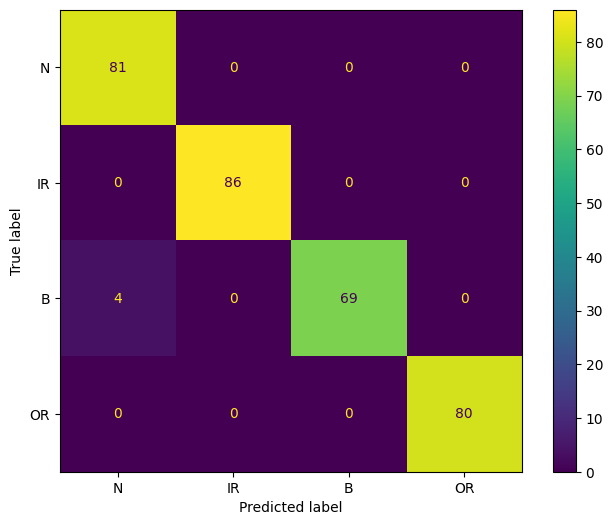

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/ResNeXt_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfResNeXt = {'Modelname':['ResNeXt_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

**For Ims Data**

In [ ]:
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[-1])
Model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
Model.fc = ResNetFC(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning ResNeXt model for traget data: {tarData[-1]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/ResNeXt_'+tarData[-1]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 77.8MB/s]


Fine tuning ResNeXt model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 79.05    Val Accuracy = 82.03
[1/20]   Train Accuracy = 94.73    Val Accuracy = 83.40
[2/20]   Train Accuracy = 97.61    Val Accuracy = 82.42
[3/20]   Train Accuracy = 99.22    Val Accuracy = 84.38
[4/20]   Train Accuracy = 99.76    Val Accuracy = 81.64
[5/20]   Train Accuracy = 99.76    Val Accuracy = 82.03
[6/20]   Train Accuracy = 99.80    Val Accuracy = 84.96
[7/20]   Train Accuracy = 99.51    Val Accuracy = 84.38
[8/20]   Train Accuracy = 99.95    Val Accuracy = 85.94
[9/20]   Train Accuracy = 99.90    Val Accuracy = 85.74
[10/20]   Train Accuracy = 99.90    Val Accuracy = 84.57
[11/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[12/20]   Train Accuracy = 100.00    Val Accuracy = 84.77
[13/20]   Train Accuracy = 99.56    Val Accuracy = 82.42
[14/20]   Train Accuracy = 99.51    Val Accuracy = 82.62
[15/20]   Train Accuracy = 99.90    Val Accuracy = 85.94
[16/20]   Train Acc

Validation Accuracy =  83.125
__________________________________________________
Pricision Score = 0.8344157228822277
__________________________________________________
F_1 Score =  0.8316061094049356
__________________________________________________
Recall Score =  0.83125
__________________________________________________
Response time per batch 0.011136054992675781


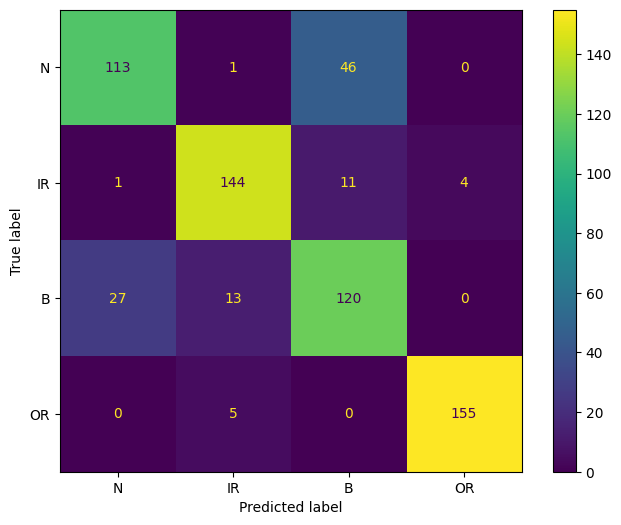

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/ResNeXt_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfResNeXt = {'Modelname':['ResNeXt_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### DenseNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = DenseNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning DenseNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/DenseNet_'+tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 66.60    Val Accuracy = 96.88
[1/20]   Train Accuracy = 99.41    Val Accuracy = 98.05
[2/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[3/20]   Train Accuracy = 99.51    Val Accuracy = 96.88
[4/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[5/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[6/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[9/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[10/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[11/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[12/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[13/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[14/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 60.16    Val Accuracy = 90.62
[1/20]   Train Accuracy = 98.63    Val Accuracy = 96.88
[2/20]   Train Accuracy = 99.61    Val Accuracy = 99.61
[3/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[4/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[5/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[6/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[7/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[8/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[9/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[10/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[11/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[12/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[13/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[14/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[15/20]   Train Accuracy = 100.00    Val Accuracy = 100.00

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 64.65    Val Accuracy = 91.41
[1/20]   Train Accuracy = 98.54    Val Accuracy = 96.48
[2/20]   Train Accuracy = 99.90    Val Accuracy = 93.75
[3/20]   Train Accuracy = 99.80    Val Accuracy = 98.05
[4/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[5/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[6/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[9/20]   Train Accuracy = 99.90    Val Accuracy = 98.44
[10/20]   Train Accuracy = 99.90    Val Accuracy = 99.61
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[12/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[13/20]   Train Accuracy = 100.00    Val Accuracy = 100.00
[14/20]   Train Accuracy = 99.90    Val Accuracy = 96.09
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 58.30    Val Accuracy = 85.55
[1/20]   Train Accuracy = 93.46    Val Accuracy = 89.06
[2/20]   Train Accuracy = 98.63    Val Accuracy = 93.75
[3/20]   Train Accuracy = 99.61    Val Accuracy = 92.19
[4/20]   Train Accuracy = 99.90    Val Accuracy = 91.41
[5/20]   Train Accuracy = 99.80    Val Accuracy = 94.53
[6/20]   Train Accuracy = 99.90    Val Accuracy = 93.36
[7/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[9/20]   Train Accuracy = 99.12    Val Accuracy = 92.19
[10/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[11/20]   Train Accuracy = 99.80    Val Accuracy = 92.19
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[13/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[14/20]   Train Accuracy = 99.61    Val Accuracy = 95.31
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 43.55    Val Accuracy = 86.72
[1/20]   Train Accuracy = 96.09    Val Accuracy = 88.28
[2/20]   Train Accuracy = 99.02    Val Accuracy = 94.53
[3/20]   Train Accuracy = 99.71    Val Accuracy = 93.36
[4/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[5/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[6/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[7/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[10/20]   Train Accuracy = 99.51    Val Accuracy = 95.70
[11/20]   Train Accuracy = 99.90    Val Accuracy = 97.27
[12/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[13/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[15/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 60.06    Val Accuracy = 93.36
[1/20]   Train Accuracy = 96.88    Val Accuracy = 95.70
[2/20]   Train Accuracy = 99.61    Val Accuracy = 92.19
[3/20]   Train Accuracy = 98.34    Val Accuracy = 97.66
[4/20]   Train Accuracy = 99.80    Val Accuracy = 96.88
[5/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[6/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[7/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[8/20]   Train Accuracy = 99.80    Val Accuracy = 95.70
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[13/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[14/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 61.62    Val Accuracy = 92.19
[1/20]   Train Accuracy = 97.17    Val Accuracy = 95.31
[2/20]   Train Accuracy = 99.32    Val Accuracy = 97.66
[3/20]   Train Accuracy = 99.71    Val Accuracy = 95.70
[4/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[5/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[6/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[9/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[13/20]   Train Accuracy = 99.90    Val Accuracy = 98.05
[14/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[15/20]   Train Accuracy = 99.80    Val Accuracy = 98.05
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 59.18    Val Accuracy = 85.94
[1/20]   Train Accuracy = 92.87    Val Accuracy = 86.72
[2/20]   Train Accuracy = 97.46    Val Accuracy = 88.28
[3/20]   Train Accuracy = 99.51    Val Accuracy = 83.20
[4/20]   Train Accuracy = 99.51    Val Accuracy = 87.50
[5/20]   Train Accuracy = 99.90    Val Accuracy = 90.23
[6/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[7/20]   Train Accuracy = 99.41    Val Accuracy = 91.02
[8/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[9/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[10/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[11/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[13/20]   Train Accuracy = 99.90    Val Accuracy = 90.23
[14/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[15/20]   Train Accuracy = 99.90    Val Accuracy = 85.94
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning DenseNet model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 47.75    Val Accuracy = 74.61
[1/20]   Train Accuracy = 89.94    Val Accuracy = 80.47
[2/20]   Train Accuracy = 97.85    Val Accuracy = 85.55
[3/20]   Train Accuracy = 98.93    Val Accuracy = 89.45
[4/20]   Train Accuracy = 98.05    Val Accuracy = 87.50
[5/20]   Train Accuracy = 99.90    Val Accuracy = 89.84
[6/20]   Train Accuracy = 99.80    Val Accuracy = 87.11
[7/20]   Train Accuracy = 100.00    Val Accuracy = 89.06
[8/20]   Train Accuracy = 99.90    Val Accuracy = 87.11
[9/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[10/20]   Train Accuracy = 99.61    Val Accuracy = 86.72
[11/20]   Train Accuracy = 99.90    Val Accuracy = 90.62
[12/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[13/20]   Train Accuracy = 100.00    Val Accuracy = 83.98
[14/20]   Train Accuracy = 99.80    Val Accuracy = 89.06
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[16/20]   T

Validation Accuracy =  99.375
__________________________________________________
Pricision Score = 0.9939759036144579
__________________________________________________
F_1 Score =  0.9934789972899729
__________________________________________________
Recall Score =  0.9931506849315068
__________________________________________________
Response time per batch 0.017931461334228516


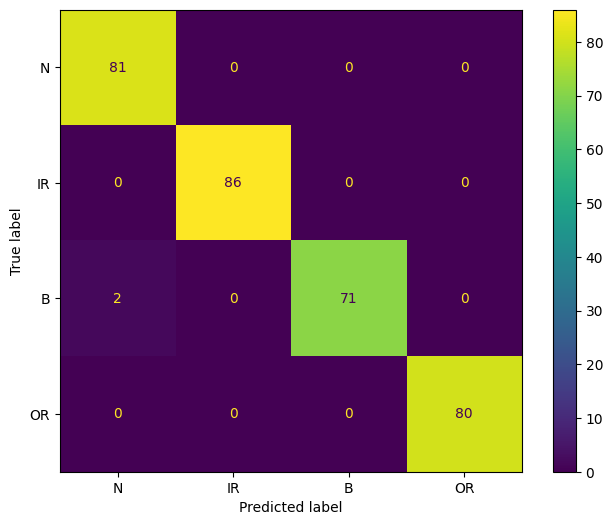

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/DenseNet_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfDenseNet = {'Modelname':['DenseNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

**IMS data**

In [ ]:
# TrainLoader, TestLoader, ValLoader = loaddata(root_path, tarData[tar])
Model = DenseNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning DenseNet model for traget data: {tarData[-1]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/DenseNet_'+tarData[-1]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 74.6MB/s]


Fine tuning DenseNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 71.53    Val Accuracy = 82.42
[1/20]   Train Accuracy = 93.75    Val Accuracy = 79.69
[2/20]   Train Accuracy = 97.75    Val Accuracy = 81.84
[3/20]   Train Accuracy = 99.32    Val Accuracy = 83.40
[4/20]   Train Accuracy = 99.80    Val Accuracy = 81.84
[5/20]   Train Accuracy = 99.80    Val Accuracy = 82.62
[6/20]   Train Accuracy = 99.95    Val Accuracy = 84.18
[7/20]   Train Accuracy = 99.51    Val Accuracy = 83.59
[8/20]   Train Accuracy = 100.00    Val Accuracy = 83.20
[9/20]   Train Accuracy = 99.46    Val Accuracy = 84.18
[10/20]   Train Accuracy = 100.00    Val Accuracy = 84.18
[11/20]   Train Accuracy = 100.00    Val Accuracy = 83.59
[12/20]   Train Accuracy = 99.95    Val Accuracy = 83.98
[13/20]   Train Accuracy = 99.71    Val Accuracy = 84.38
[14/20]   Train Accuracy = 99.90    Val Accuracy = 83.40
[15/20]   Train Accuracy = 100.00    Val Accuracy = 85.94
[16/20]   Train 

Validation Accuracy =  82.5
__________________________________________________
Pricision Score = 0.8379114209189353
__________________________________________________
F_1 Score =  0.820998383268521
__________________________________________________
Recall Score =  0.825
__________________________________________________
Response time per batch 0.01903367042541504


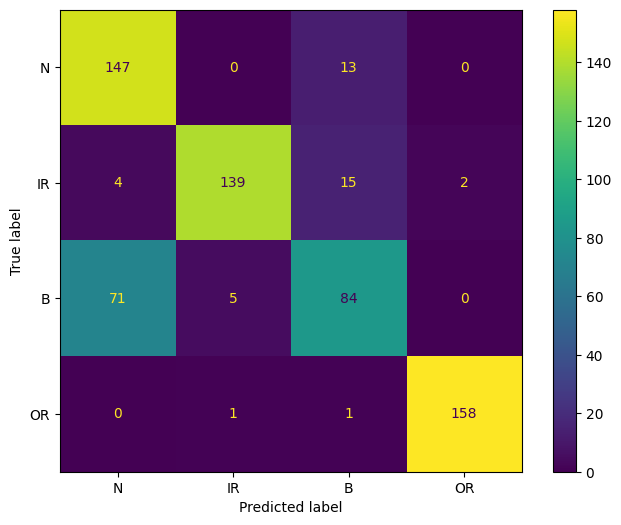

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/DenseNet_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfDenseNet = {'Modelname':['DenseNet_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### vgg16Net

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = vgg16Net(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning vgg16Net model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/vgg16Net_'+tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.8MB/s]


Fine tuning vgg16Net model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 79.59    Val Accuracy = 93.75
[1/20]   Train Accuracy = 98.54    Val Accuracy = 95.70
[2/20]   Train Accuracy = 99.32    Val Accuracy = 98.44
[3/20]   Train Accuracy = 99.51    Val Accuracy = 93.75
[4/20]   Train Accuracy = 98.54    Val Accuracy = 94.92
[5/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[6/20]   Train Accuracy = 99.61    Val Accuracy = 96.48
[7/20]   Train Accuracy = 99.90    Val Accuracy = 98.83
[8/20]   Train Accuracy = 99.61    Val Accuracy = 92.97
[9/20]   Train Accuracy = 99.80    Val Accuracy = 98.44
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 71.29    Val Accuracy = 94.92
[1/20]   Train Accuracy = 97.36    Val Accuracy = 97.27
[2/20]   Train Accuracy = 99.12    Val Accuracy = 98.44
[3/20]   Train Accuracy = 99.02    Val Accuracy = 99.22
[4/20]   Train Accuracy = 99.80    Val Accuracy = 98.44
[5/20]   Train Accuracy = 99.80    Val Accuracy = 98.44
[6/20]   Train Accuracy = 99.61    Val Accuracy = 99.22
[7/20]   Train Accuracy = 99.71    Val Accuracy = 99.61
[8/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[9/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[10/20]   Train Accuracy = 99.61    Val Accuracy = 99.22
[11/20]   Train Accuracy = 99.61    Val Accuracy = 99.22
[12/20]   Train Accuracy = 99.90    Val Accuracy = 97.66
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 80.96    Val Accuracy = 91.02
[1/20]   Train Accuracy = 98.05    Val Accuracy = 94.53
[2/20]   Train Accuracy = 99.61    Val Accuracy = 98.05
[3/20]   Train Accuracy = 99.51    Val Accuracy = 97.27
[4/20]   Train Accuracy = 99.32    Val Accuracy = 95.70
[5/20]   Train Accuracy = 99.51    Val Accuracy = 97.27
[6/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[7/20]   Train Accuracy = 99.51    Val Accuracy = 98.83
[8/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[9/20]   Train Accuracy = 99.12    Val Accuracy = 90.62
[10/20]   Train Accuracy = 99.71    Val Accuracy = 97.27
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[16/20]   T

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 57.91    Val Accuracy = 73.05
[1/20]   Train Accuracy = 86.52    Val Accuracy = 90.23
[2/20]   Train Accuracy = 92.19    Val Accuracy = 91.02
[3/20]   Train Accuracy = 95.31    Val Accuracy = 92.58
[4/20]   Train Accuracy = 96.29    Val Accuracy = 96.09
[5/20]   Train Accuracy = 98.83    Val Accuracy = 92.97
[6/20]   Train Accuracy = 98.73    Val Accuracy = 97.66
[7/20]   Train Accuracy = 99.22    Val Accuracy = 96.48
[8/20]   Train Accuracy = 99.71    Val Accuracy = 96.09
[9/20]   Train Accuracy = 99.41    Val Accuracy = 89.06
[10/20]   Train Accuracy = 97.95    Val Accuracy = 97.66
[11/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[13/20]   Train Accuracy = 99.12    Val Accuracy = 93.36
[14/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[15/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[16/20]   Trai

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 71.00    Val Accuracy = 89.84
[1/20]   Train Accuracy = 95.02    Val Accuracy = 94.92
[2/20]   Train Accuracy = 96.58    Val Accuracy = 93.75
[3/20]   Train Accuracy = 98.24    Val Accuracy = 97.27
[4/20]   Train Accuracy = 98.05    Val Accuracy = 93.75
[5/20]   Train Accuracy = 99.02    Val Accuracy = 97.66
[6/20]   Train Accuracy = 99.71    Val Accuracy = 96.48
[7/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[8/20]   Train Accuracy = 99.71    Val Accuracy = 98.05
[9/20]   Train Accuracy = 99.32    Val Accuracy = 96.09
[10/20]   Train Accuracy = 99.61    Val Accuracy = 97.66
[11/20]   Train Accuracy = 99.90    Val Accuracy = 97.27
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[13/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[15/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[16/20]   Tr

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 67.29    Val Accuracy = 91.02
[1/20]   Train Accuracy = 92.77    Val Accuracy = 83.98
[2/20]   Train Accuracy = 96.88    Val Accuracy = 94.14
[3/20]   Train Accuracy = 98.14    Val Accuracy = 97.27
[4/20]   Train Accuracy = 98.54    Val Accuracy = 95.31
[5/20]   Train Accuracy = 97.56    Val Accuracy = 96.88
[6/20]   Train Accuracy = 99.61    Val Accuracy = 96.88
[7/20]   Train Accuracy = 98.54    Val Accuracy = 93.75
[8/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[9/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[11/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[12/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 69.53    Val Accuracy = 87.11
[1/20]   Train Accuracy = 91.11    Val Accuracy = 87.89
[2/20]   Train Accuracy = 93.46    Val Accuracy = 95.70
[3/20]   Train Accuracy = 98.24    Val Accuracy = 96.48
[4/20]   Train Accuracy = 98.54    Val Accuracy = 93.75
[5/20]   Train Accuracy = 98.24    Val Accuracy = 93.75
[6/20]   Train Accuracy = 98.63    Val Accuracy = 96.88
[7/20]   Train Accuracy = 99.71    Val Accuracy = 96.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[10/20]   Train Accuracy = 99.61    Val Accuracy = 96.09
[11/20]   Train Accuracy = 99.80    Val Accuracy = 94.53
[12/20]   Train Accuracy = 99.61    Val Accuracy = 93.36
[13/20]   Train Accuracy = 99.90    Val Accuracy = 97.66
[14/20]   Train Accuracy = 98.54    Val Accuracy = 94.92
[15/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[16/20]   Trai

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 50.78    Val Accuracy = 79.69
[1/20]   Train Accuracy = 79.10    Val Accuracy = 61.33
[2/20]   Train Accuracy = 89.94    Val Accuracy = 77.34
[3/20]   Train Accuracy = 93.55    Val Accuracy = 86.72
[4/20]   Train Accuracy = 94.24    Val Accuracy = 77.73
[5/20]   Train Accuracy = 95.21    Val Accuracy = 89.45
[6/20]   Train Accuracy = 97.17    Val Accuracy = 89.84
[7/20]   Train Accuracy = 98.73    Val Accuracy = 89.06
[8/20]   Train Accuracy = 99.12    Val Accuracy = 92.19
[9/20]   Train Accuracy = 98.05    Val Accuracy = 88.67
[10/20]   Train Accuracy = 99.61    Val Accuracy = 85.16
[11/20]   Train Accuracy = 99.71    Val Accuracy = 83.98
[12/20]   Train Accuracy = 99.71    Val Accuracy = 83.20
[13/20]   Train Accuracy = 99.02    Val Accuracy = 91.02
[14/20]   Train Accuracy = 98.73    Val Accuracy = 88.28
[15/20]   Train Accuracy = 99.90    Val Accuracy = 91.02
[16/20]   Train 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning vgg16Net model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 61.04    Val Accuracy = 79.30
[1/20]   Train Accuracy = 77.73    Val Accuracy = 69.92
[2/20]   Train Accuracy = 86.33    Val Accuracy = 85.55
[3/20]   Train Accuracy = 91.70    Val Accuracy = 85.16
[4/20]   Train Accuracy = 95.90    Val Accuracy = 79.69
[5/20]   Train Accuracy = 96.58    Val Accuracy = 88.28
[6/20]   Train Accuracy = 98.24    Val Accuracy = 91.80
[7/20]   Train Accuracy = 98.83    Val Accuracy = 81.25
[8/20]   Train Accuracy = 99.22    Val Accuracy = 89.06
[9/20]   Train Accuracy = 99.80    Val Accuracy = 91.41
[10/20]   Train Accuracy = 99.22    Val Accuracy = 77.73
[11/20]   Train Accuracy = 99.22    Val Accuracy = 87.89
[12/20]   Train Accuracy = 99.80    Val Accuracy = 83.59
[13/20]   Train Accuracy = 99.80    Val Accuracy = 90.23
[14/20]   Train Accuracy = 99.90    Val Accuracy = 89.06
[15/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[16/20]   Train

Validation Accuracy =  99.375
__________________________________________________
Pricision Score = 0.9939759036144579
__________________________________________________
F_1 Score =  0.9934789972899729
__________________________________________________
Recall Score =  0.9931506849315068
__________________________________________________
Response time per batch 0.0019958019256591797


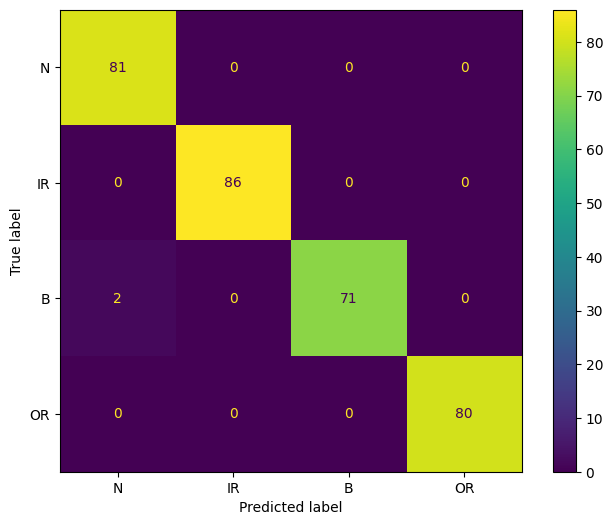

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/vgg16Net_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvgg16Net = {'Modelname':['vgg16Net_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [ ]:
tar = -1
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
Model = vgg16Net(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning vgg16Net model for traget data: {tarData[-1]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/vgg16Net_'+tarData[-1]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


Fine tuning vgg16Net model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 76.56    Val Accuracy = 79.10
[1/20]   Train Accuracy = 85.45    Val Accuracy = 83.40
[2/20]   Train Accuracy = 90.19    Val Accuracy = 85.16
[3/20]   Train Accuracy = 92.77    Val Accuracy = 86.33
[4/20]   Train Accuracy = 94.34    Val Accuracy = 81.25
[5/20]   Train Accuracy = 95.46    Val Accuracy = 85.94
[6/20]   Train Accuracy = 97.61    Val Accuracy = 84.96
[7/20]   Train Accuracy = 99.37    Val Accuracy = 86.91
[8/20]   Train Accuracy = 99.80    Val Accuracy = 84.18
[9/20]   Train Accuracy = 99.66    Val Accuracy = 87.11
[10/20]   Train Accuracy = 99.71    Val Accuracy = 84.96
[11/20]   Train Accuracy = 99.56    Val Accuracy = 83.20
[12/20]   Train Accuracy = 100.00    Val Accuracy = 85.55
[13/20]   Train Accuracy = 99.95    Val Accuracy = 86.33
[14/20]   Train Accuracy = 100.00    Val Accuracy = 87.11
[15/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[16/20]   Train A

Validation Accuracy =  88.125
__________________________________________________
Pricision Score = 0.8827205066641309
__________________________________________________
F_1 Score =  0.8817851834156183
__________________________________________________
Recall Score =  0.88125
__________________________________________________
Response time per batch 0.003473997116088867


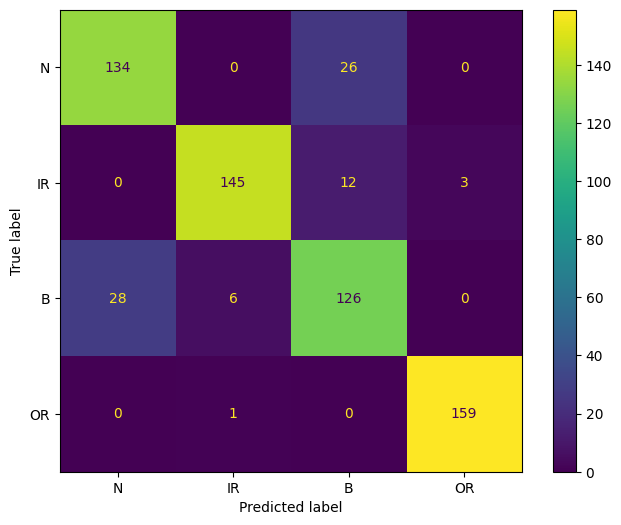

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/vgg16Net_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfvgg16Net = {'Modelname':['vgg16Net_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### GoogleNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = googleNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning GoogleNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/GoogleNet_'+tarData[tar]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 59.86    Val Accuracy = 85.94
[1/20]   Train Accuracy = 97.95    Val Accuracy = 94.53
[2/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[3/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[4/20]   Train Accuracy = 99.90    Val Accuracy = 93.36
[5/20]   Train Accuracy = 99.71    Val Accuracy = 97.66
[6/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[9/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[10/20]   Train Accuracy = 99.90    Val Accuracy = 97.27
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[12/20]   Train Accuracy = 99.90    Val Accuracy = 98.83
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[14/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 59.18    Val Accuracy = 86.33
[1/20]   Train Accuracy = 96.48    Val Accuracy = 96.09
[2/20]   Train Accuracy = 99.90    Val Accuracy = 96.09
[3/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[4/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[5/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[6/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[7/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[10/20]   Train Accuracy = 99.80    Val Accuracy = 98.05
[11/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[12/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[14/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[15/20]   Train Accuracy = 100.00    Val Accuracy = 99.61
[16/2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 58.11    Val Accuracy = 91.02
[1/20]   Train Accuracy = 98.34    Val Accuracy = 96.09
[2/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[3/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[4/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[5/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[6/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[12/20]   Train Accuracy = 99.90    Val Accuracy = 96.09
[13/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[14/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[16/2

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 53.91    Val Accuracy = 82.03
[1/20]   Train Accuracy = 89.16    Val Accuracy = 89.84
[2/20]   Train Accuracy = 97.36    Val Accuracy = 92.97
[3/20]   Train Accuracy = 98.93    Val Accuracy = 91.02
[4/20]   Train Accuracy = 99.90    Val Accuracy = 91.80
[5/20]   Train Accuracy = 100.00    Val Accuracy = 90.23
[6/20]   Train Accuracy = 99.22    Val Accuracy = 91.80
[7/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[8/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[9/20]   Train Accuracy = 99.71    Val Accuracy = 94.92
[10/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[11/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[13/20]   Train Accuracy = 99.80    Val Accuracy = 94.92
[14/20]   Train Accuracy = 99.51    Val Accuracy = 91.41
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.31
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 49.80    Val Accuracy = 76.17
[1/20]   Train Accuracy = 89.45    Val Accuracy = 89.84
[2/20]   Train Accuracy = 98.34    Val Accuracy = 93.36
[3/20]   Train Accuracy = 99.61    Val Accuracy = 95.31
[4/20]   Train Accuracy = 99.61    Val Accuracy = 94.53
[5/20]   Train Accuracy = 99.71    Val Accuracy = 93.75
[6/20]   Train Accuracy = 99.71    Val Accuracy = 96.48
[7/20]   Train Accuracy = 99.61    Val Accuracy = 97.27
[8/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[10/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[11/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[12/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[13/20]   Train Accuracy = 99.80    Val Accuracy = 95.31
[14/20]   Train Accuracy = 99.90    Val Accuracy = 96.09
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[16/20]   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 52.83    Val Accuracy = 75.39
[1/20]   Train Accuracy = 91.11    Val Accuracy = 92.19
[2/20]   Train Accuracy = 98.93    Val Accuracy = 93.36
[3/20]   Train Accuracy = 99.90    Val Accuracy = 95.31
[4/20]   Train Accuracy = 99.71    Val Accuracy = 95.31
[5/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[6/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[7/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[8/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[9/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[10/20]   Train Accuracy = 99.90    Val Accuracy = 93.75
[11/20]   Train Accuracy = 99.80    Val Accuracy = 93.36
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[13/20]   Train Accuracy = 100.00    Val Accuracy = 92.19
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[15/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[16/20] 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_1
Starting Training Loop...
[0/20]   Train Accuracy = 59.77    Val Accuracy = 88.28
[1/20]   Train Accuracy = 93.65    Val Accuracy = 94.92
[2/20]   Train Accuracy = 98.83    Val Accuracy = 94.53
[3/20]   Train Accuracy = 99.71    Val Accuracy = 96.48
[4/20]   Train Accuracy = 99.71    Val Accuracy = 96.48
[5/20]   Train Accuracy = 99.71    Val Accuracy = 94.53
[6/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 94.92
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[9/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[10/20]   Train Accuracy = 99.90    Val Accuracy = 98.44
[11/20]   Train Accuracy = 99.90    Val Accuracy = 97.27
[12/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[13/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[14/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[15/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_2
Starting Training Loop...
[0/20]   Train Accuracy = 59.28    Val Accuracy = 80.47
[1/20]   Train Accuracy = 91.50    Val Accuracy = 91.80
[2/20]   Train Accuracy = 98.73    Val Accuracy = 91.02
[3/20]   Train Accuracy = 99.61    Val Accuracy = 92.58
[4/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[5/20]   Train Accuracy = 99.90    Val Accuracy = 91.02
[6/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[7/20]   Train Accuracy = 99.80    Val Accuracy = 87.89
[8/20]   Train Accuracy = 100.00    Val Accuracy = 90.62
[9/20]   Train Accuracy = 100.00    Val Accuracy = 89.84
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[11/20]   Train Accuracy = 99.90    Val Accuracy = 90.23
[12/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[13/20]   Train Accuracy = 100.00    Val Accuracy = 91.41
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[15/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning GoogleNet model for traget data: FE_tar_21_3
Starting Training Loop...
[0/20]   Train Accuracy = 54.59    Val Accuracy = 71.09
[1/20]   Train Accuracy = 87.79    Val Accuracy = 87.11
[2/20]   Train Accuracy = 96.78    Val Accuracy = 83.98
[3/20]   Train Accuracy = 99.12    Val Accuracy = 84.77
[4/20]   Train Accuracy = 99.61    Val Accuracy = 83.59
[5/20]   Train Accuracy = 98.34    Val Accuracy = 87.50
[6/20]   Train Accuracy = 99.90    Val Accuracy = 87.50
[7/20]   Train Accuracy = 100.00    Val Accuracy = 91.02
[8/20]   Train Accuracy = 99.90    Val Accuracy = 87.89
[9/20]   Train Accuracy = 99.71    Val Accuracy = 85.16
[10/20]   Train Accuracy = 100.00    Val Accuracy = 85.55
[11/20]   Train Accuracy = 100.00    Val Accuracy = 87.89
[12/20]   Train Accuracy = 99.90    Val Accuracy = 85.94
[13/20]   Train Accuracy = 100.00    Val Accuracy = 86.72
[14/20]   Train Accuracy = 99.90    Val Accuracy = 86.33
[15/20]   Train Accuracy = 99.80    Val Accuracy = 88.28
[16/20]   T

Validation Accuracy =  97.5
__________________________________________________
Pricision Score = 0.9747334769231741
__________________________________________________
F_1 Score =  0.9741697384754782
__________________________________________________
Recall Score =  0.9738013698630137
__________________________________________________
Response time per batch 0.009088754653930664


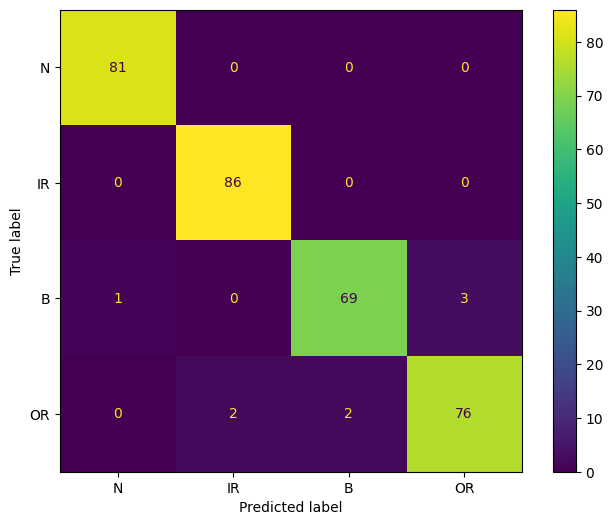

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/GoogleNet_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfgoogleNet = {'Modelname':['GoogleNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

**For IMS data**

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
Model = googleNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning GoogleNet model for traget data: {tarData[-1]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/GoogleNet_'+tarData[-1]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 142MB/s]


Fine tuning GoogleNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 68.85    Val Accuracy = 80.08
[1/20]   Train Accuracy = 93.80    Val Accuracy = 82.23
[2/20]   Train Accuracy = 99.12    Val Accuracy = 81.45
[3/20]   Train Accuracy = 99.66    Val Accuracy = 76.17
[4/20]   Train Accuracy = 99.66    Val Accuracy = 82.81
[5/20]   Train Accuracy = 99.85    Val Accuracy = 82.42
[6/20]   Train Accuracy = 99.41    Val Accuracy = 81.84
[7/20]   Train Accuracy = 99.22    Val Accuracy = 82.42
[8/20]   Train Accuracy = 99.80    Val Accuracy = 81.64
[9/20]   Train Accuracy = 99.85    Val Accuracy = 78.71
[10/20]   Train Accuracy = 99.85    Val Accuracy = 81.64
[11/20]   Train Accuracy = 99.85    Val Accuracy = 80.66
[12/20]   Train Accuracy = 100.00    Val Accuracy = 81.64
[13/20]   Train Accuracy = 100.00    Val Accuracy = 82.23
[14/20]   Train Accuracy = 100.00    Val Accuracy = 81.84
[15/20]   Train Accuracy = 100.00    Val Accuracy = 80.66
[16/20]   Train

Validation Accuracy =  80.9375
__________________________________________________
Pricision Score = 0.8171151978878876
__________________________________________________
F_1 Score =  0.8071452231124399
__________________________________________________
Recall Score =  0.809375
__________________________________________________
Response time per batch 0.009241580963134766


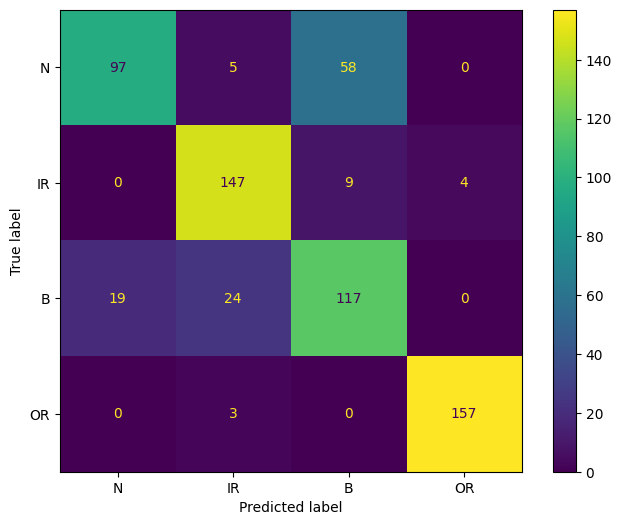

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/GoogleNet_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfgoogleNet = {'Modelname':['GoogleNet_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

### SqeezeNet

In [ ]:
# Main Training loop for all target dataset with pretrained sourse model on CWRU DE fault, Dia=7Mil, load = 0hp

for tar in range(len(tarData)):
    TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[tar])
    Model = SqeezeNet(numClass)
    Model.to(device)
    optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    print(f'Fine tuning SqeezeNet model for traget data: {tarData[tar]}')
    Model = train(Model, TrainLoader, ValLoader, optC, criterion)
    torch.save(Model,'./saved_models/SqeezeNet_'+tarData[tar]+'.pth')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 38.1MB/s]


Fine tuning SqeezeNet model for traget data: FE_tar_7_1
Starting Training Loop...
[0/20]   Train Accuracy = 82.91    Val Accuracy = 92.58
[1/20]   Train Accuracy = 99.61    Val Accuracy = 96.48
[2/20]   Train Accuracy = 99.32    Val Accuracy = 96.88
[3/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[4/20]   Train Accuracy = 100.00    Val Accuracy = 97.27
[5/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[6/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[7/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[8/20]   Train Accuracy = 99.90    Val Accuracy = 95.70
[9/20]   Train Accuracy = 99.61    Val Accuracy = 97.66
[10/20]   Train Accuracy = 99.71    Val Accuracy = 97.66
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[14/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_7_2
Starting Training Loop...
[0/20]   Train Accuracy = 76.66    Val Accuracy = 96.09
[1/20]   Train Accuracy = 98.34    Val Accuracy = 97.27
[2/20]   Train Accuracy = 99.41    Val Accuracy = 98.83
[3/20]   Train Accuracy = 99.80    Val Accuracy = 98.83
[4/20]   Train Accuracy = 99.90    Val Accuracy = 99.61
[5/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[6/20]   Train Accuracy = 99.80    Val Accuracy = 98.83
[7/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[8/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[10/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[13/20]   Train Accuracy = 99.90    Val Accuracy = 94.92
[14/20]   Train Accuracy = 99.71    Val Accuracy = 99.61
[15/20]   Train Accuracy = 99.71    Val Accuracy = 99.22
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_7_3
Starting Training Loop...
[0/20]   Train Accuracy = 79.98    Val Accuracy = 91.02
[1/20]   Train Accuracy = 98.44    Val Accuracy = 96.09
[2/20]   Train Accuracy = 99.61    Val Accuracy = 98.05
[3/20]   Train Accuracy = 99.80    Val Accuracy = 97.27
[4/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[5/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[6/20]   Train Accuracy = 100.00    Val Accuracy = 99.22
[7/20]   Train Accuracy = 100.00    Val Accuracy = 97.66
[8/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[9/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[10/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[11/20]   Train Accuracy = 100.00    Val Accuracy = 98.44
[12/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[13/20]   Train Accuracy = 100.00    Val Accuracy = 98.83
[14/20]   Train Accuracy = 100.00    Val Accuracy = 94.53
[15/20]   Train Accuracy = 100.00    Val Accuracy = 98.05
[16/20

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_1
Starting Training Loop...
[0/20]   Train Accuracy = 67.19    Val Accuracy = 87.89
[1/20]   Train Accuracy = 91.11    Val Accuracy = 87.50
[2/20]   Train Accuracy = 94.92    Val Accuracy = 90.23
[3/20]   Train Accuracy = 98.05    Val Accuracy = 93.36
[4/20]   Train Accuracy = 98.63    Val Accuracy = 92.19
[5/20]   Train Accuracy = 99.61    Val Accuracy = 87.89
[6/20]   Train Accuracy = 99.80    Val Accuracy = 92.97
[7/20]   Train Accuracy = 98.93    Val Accuracy = 92.97
[8/20]   Train Accuracy = 100.00    Val Accuracy = 92.97
[9/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[10/20]   Train Accuracy = 100.00    Val Accuracy = 92.58
[11/20]   Train Accuracy = 100.00    Val Accuracy = 94.14
[12/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[13/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[14/20]   Train Accuracy = 100.00    Val Accuracy = 93.36
[15/20]   Train Accuracy = 100.00    Val Accuracy = 93.75
[16/20]

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_2
Starting Training Loop...
[0/20]   Train Accuracy = 72.46    Val Accuracy = 78.12
[1/20]   Train Accuracy = 94.73    Val Accuracy = 94.92
[2/20]   Train Accuracy = 98.14    Val Accuracy = 96.48
[3/20]   Train Accuracy = 99.12    Val Accuracy = 97.66
[4/20]   Train Accuracy = 99.51    Val Accuracy = 96.88
[5/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[6/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[8/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[9/20]   Train Accuracy = 100.00    Val Accuracy = 95.70
[10/20]   Train Accuracy = 100.00    Val Accuracy = 96.88
[11/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[12/20]   Train Accuracy = 98.24    Val Accuracy = 91.02
[13/20]   Train Accuracy = 99.51    Val Accuracy = 95.31
[14/20]   Train Accuracy = 99.80    Val Accuracy = 98.05
[15/20]   Train Accuracy = 100.00    Val Accuracy = 96.48
[16/20]  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Fine tuning SqeezeNet model for traget data: FE_tar_14_3
Starting Training Loop...
[0/20]   Train Accuracy = 72.36    Val Accuracy = 77.73
[1/20]   Train Accuracy = 93.75    Val Accuracy = 93.75
[2/20]   Train Accuracy = 97.95    Val Accuracy = 96.48
[3/20]   Train Accuracy = 98.73    Val Accuracy = 95.31
[4/20]   Train Accuracy = 99.61    Val Accuracy = 94.53
[5/20]   Train Accuracy = 99.80    Val Accuracy = 96.48
[6/20]   Train Accuracy = 99.90    Val Accuracy = 96.88
[7/20]   Train Accuracy = 100.00    Val Accuracy = 96.09
[8/20]   Train Accuracy = 99.90    Val Accuracy = 96.48
[9/20]   Train Accuracy = 99.80    Val Accuracy = 94.14


Validation Accuracy =  98.75
__________________________________________________
Pricision Score = 0.9878783426388481
__________________________________________________
F_1 Score =  0.9868225462379819
__________________________________________________
Recall Score =  0.9863013698630136
__________________________________________________
Response time per batch 0.002973318099975586


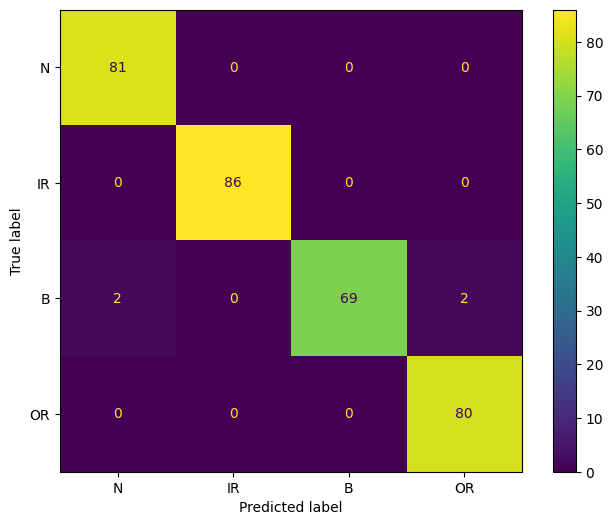

In [ ]:
# Validate and Visualize
TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/SqeezeNet_'+tarData[0]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

**For IMS data**

In [ ]:
Model = SqeezeNet(numClass)
Model.to(device)
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
print(f'Fine tuning SqeezeNet model for traget data: {tarData[-1]}')
Model = train(Model, TrainLoader, ValLoader, optC, criterion)
torch.save(Model,'./saved_models/SqeezeNet_'+tarData[-1]+'.pth')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 61.2MB/s]


Fine tuning SqeezeNet model for traget data: ims_tar
Starting Training Loop...
[0/20]   Train Accuracy = 45.12    Val Accuracy = 61.72
[1/20]   Train Accuracy = 75.54    Val Accuracy = 69.92
[2/20]   Train Accuracy = 81.45    Val Accuracy = 79.30
[3/20]   Train Accuracy = 84.86    Val Accuracy = 80.86
[4/20]   Train Accuracy = 86.67    Val Accuracy = 77.34
[5/20]   Train Accuracy = 88.38    Val Accuracy = 79.30
[6/20]   Train Accuracy = 89.16    Val Accuracy = 80.08
[7/20]   Train Accuracy = 88.67    Val Accuracy = 83.01
[8/20]   Train Accuracy = 90.04    Val Accuracy = 83.59
[9/20]   Train Accuracy = 91.06    Val Accuracy = 84.57
[10/20]   Train Accuracy = 92.53    Val Accuracy = 79.88
[11/20]   Train Accuracy = 92.58    Val Accuracy = 82.62
[12/20]   Train Accuracy = 93.02    Val Accuracy = 80.47
[13/20]   Train Accuracy = 94.24    Val Accuracy = 86.33
[14/20]   Train Accuracy = 95.21    Val Accuracy = 85.94
[15/20]   Train Accuracy = 95.07    Val Accuracy = 85.55
[16/20]   Train Acc

Validation Accuracy =  82.03125
__________________________________________________
Pricision Score = 0.8362550689392255
__________________________________________________
F_1 Score =  0.8142634852371744
__________________________________________________
Recall Score =  0.8203125
__________________________________________________
Response time per batch 0.003201007843017578


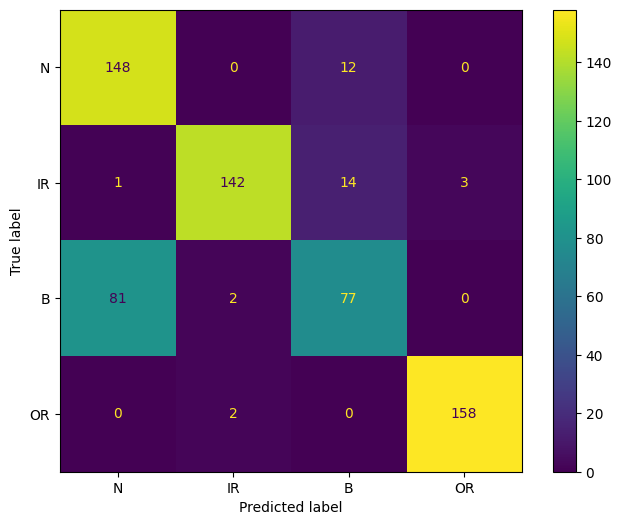

In [ ]:
# Validate and Visualize
# TrainLoader, TestLoader, ValLoader, numClass = loaddata(root_path, tarData[0])
Model = torch.load('./saved_models/SqeezeNet_'+tarData[-1]+'.pth', map_location=device)
val_acc, cm, prec, f1, recall, time_batch = validate(Model, TestLoader, numClass)
print('Validation Accuracy = ', val_acc)
print("__________________________________________________")
print(f'Pricision Score = {prec}')
print('__________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
print('__________________________________________________')
print('Response time per batch', time_batch)
disp_conf_matrix(cm)

perfSqeezeNet = {'Modelname':['SqeezeNet_'+tarData[-1]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

Text(0.5, 0, 'Training Steps')

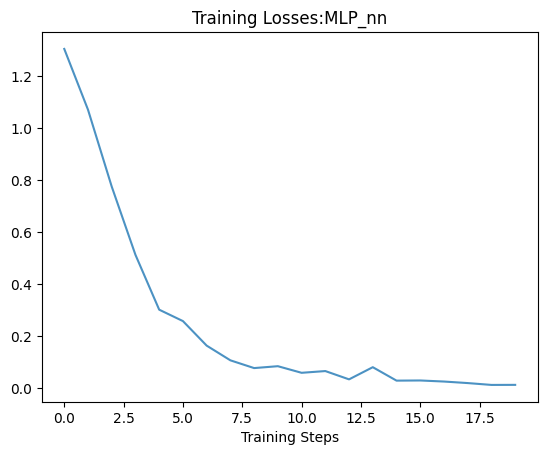

In [ ]:
fig, ax = plt.subplots()
tr_Losses = np.array(tr_Losses)
plt.plot(tr_Losses.T, label='Training Losses', alpha=0.8)
plt.title("Training Losses:MLP_nn")
plt.xlabel('Training Steps')

In [ ]:
def initialize_weights(w):
    classname = w.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [ ]:
class MyCovnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 32, 3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.Linear(64, 4)
        )

    def forward(self, x):
      return self.seq(x)

In [ ]:
Model = MyCovnet().to(device)

In [ ]:
Model.apply(initialize_weights)

MyCovnet(
  (seq): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [ ]:
#Define optimizer and loss
optC = torch.optim.Adam(Model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
Model, tr_loss, val_loss = train(Model, TrainLoader, ValLoader, optC, criterion)


Starting Training Loop...
[0/20]   Train Accuracy = 65.53    Val Accuracy = 66.25
[1/20]   Train Accuracy = 99.32    Val Accuracy = 97.19
[2/20]   Train Accuracy = 99.22    Val Accuracy = 95.62
[3/20]   Train Accuracy = 100.00    Val Accuracy = 98.75
[4/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[5/20]   Train Accuracy = 100.00    Val Accuracy = 98.75
[6/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[7/20]   Train Accuracy = 100.00    Val Accuracy = 99.38
[8/20]   Train Accuracy = 100.00    Val Accuracy = 99.38
[9/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[10/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[11/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[12/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[13/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[14/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[15/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[16/20]   Train Accuracy = 100.00    Val Accuracy = 99.06
[

In [ ]:
torch.save(Model,'./saved_models/CNN'+tarData[tar]+'.pth')

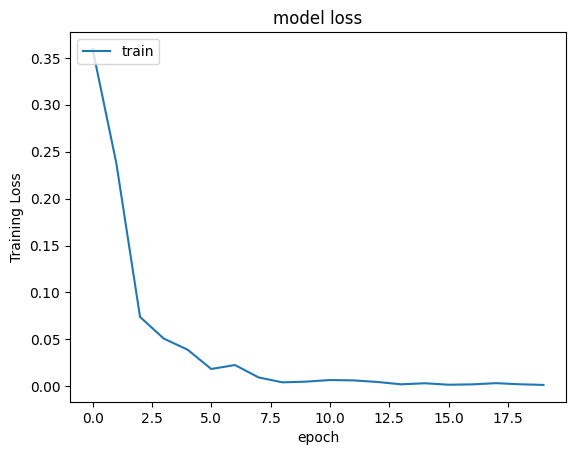

In [ ]:
trloss=np.array(tr_Losses)
plt.plot(trloss)
plt.title('model loss')
plt.ylabel('Training Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Validation Accuracy =  99.0625
_______________________________________________
Pricision Score = 0.9905036813922357
________________________________________________
F_1 Score =  0.9902064786750666
__________________________________________________
Recall Score =  0.9900256849315068


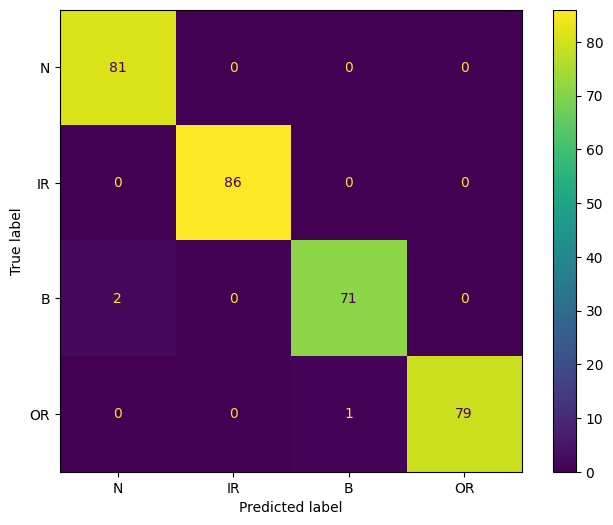

In [ ]:
# Validate and Visualize
val_acc, cm, prec, f1, recall, _ = validate(Model, TestLoader)
print('Validation Accuracy = ', val_acc)
print("_______________________________________________")
print(f'Pricision Score = {prec}')
print('________________________________________________')
print(f'F_1 Score =  {f1}')
print('__________________________________________________')
print(f"Recall Score =  {recall}")
disp_conf_matrix(cm)

perfData = {'Modelname':['CNN'+tarData[tar]], 'Val Acc.': val_acc, 'Precision':prec, 'F1_score':f1, 'Recall':recall}

In [ ]:
perfData = pd.DataFrame(perfData)
perfData.to_csv('results_CNN'+tarData[tar]+'.csv')

In [ ]:
# vitmodel = torch.load('./saved_models/ViT_custom.pth')

# **Plot Acc graph**

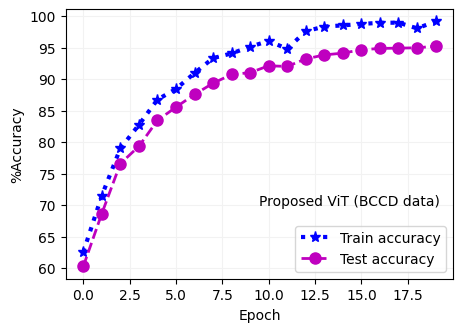

In [ ]:
df = pd.read_excel('train_hisy_vit_prop.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9.5, 70, 'Proposed ViT (BCCD data)')
plt.grid(axis='both', color='0.95')
plt.show()

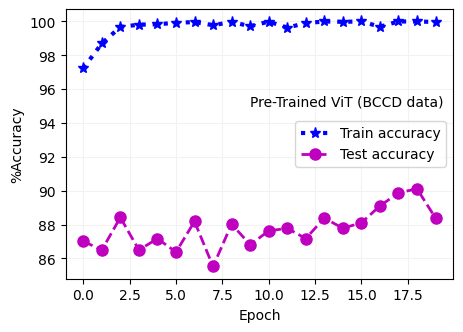

In [ ]:
df = pd.read_excel('train_hisy_vit_pre.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9, 95, 'Pre-Trained ViT (BCCD data)')
plt.grid(axis='both', color='0.95')
plt.show()

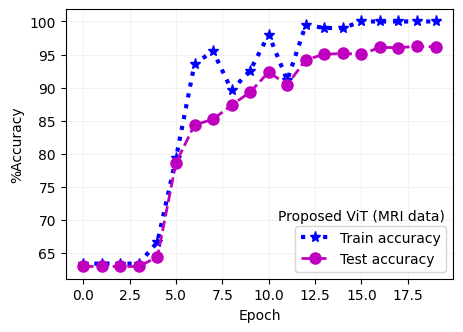

In [ ]:
df = pd.read_excel('train_hisy_vit_prop_MRI.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(10.5, 70, 'Proposed ViT (MRI data)')
plt.grid(axis='both', color='0.95')
plt.show()

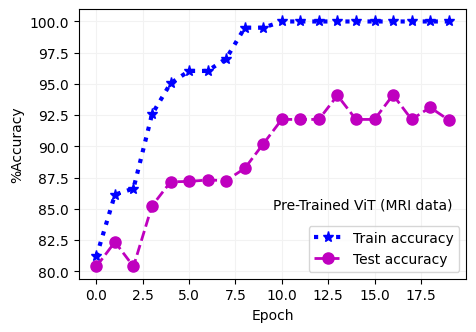

In [ ]:
df = pd.read_excel('train_hisy_vit_pre_MRI.xlsx')
fig = plt.figure(figsize=(5,3.5))
plt.plot(df['tr_acc'].values, 'b:*', linewidth=3, ms = 8)
plt.plot(df['val_acc'].values, 'm--o', linewidth=2, ms = 8)
# plt.title('trainin')
plt.ylabel('%Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])
plt.text(9.5, 85, 'Pre-Trained ViT (MRI data)')
plt.grid(axis='both', color='0.95')
plt.show()